Import des différentes librairies

In [5]:
#import pixiedust
import tweepy

import squarify 
from geopy.geocoders import Nominatim
import folium
import json_lines
import json
import time
import datetime
import random
import itertools
import os
import matplotlib.pyplot as plt
from texttable import Texttable
import jsonpickle

import pandas as pd, requests
import csv
import certifi
# pip install tweepy json_lines squarify folium geopy panda

In [6]:
tweetsPerQry = 100  # this is the max the API permits

searchQuery = '#trump'  # this is what we're searching for
maxTweets = 500 # Some arbitrary large number

language = "en"                                          # Language, must be ISO 639-1 code
#since = None                                             # Start date
#until = datetime.datetime.now().strftime("%Y-%m-%d")     # End date
#until = "2016-01-01"     # End date
result_type = "mixed"                                  # recent, popular, or mixed
geocode = None                                         # Geocode
tweet_mode='extended'

Configuration du nom du fichier utilisé

In [24]:
%env TIME={time.time()}
%env OUTPUT_TWEET_FILENAME=output_tweet_{os.environ['TIME']}.json
%env TWEET_JSON_FILENAME=input_tweet_{os.environ['TIME']}.json


env: TIME=1522074732.233345
env: OUTPUT_TWEET_FILENAME=output_tweet_1522074732.233345.json
env: TWEET_JSON_FILENAME=input_tweet_1522074732.233345.json


In [30]:
with_geo=False
API_key = json.load(open("API_key.txt", "r"))

auth = tweepy.OAuthHandler(API_key["consumer_key"], API_key["consumer_secret"])
auth.set_access_token(API_key["access_token"], API_key["access_token_secret"])
api = tweepy.API(auth)

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))

filename = "tweets-database/" + TWEET_JSON_FILENAME
with open(filename, 'w') as f:
    while tweetCount < maxTweets:
        tweetsForThisQry = min(tweetsPerQry, maxTweets-tweetCount)
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, 
                                            count=tweetsForThisQry, 
                                            lang=language, 
                                            tweet_mode=tweet_mode)
                else:
                    new_tweets = api.search(q=searchQuery, 
                                            count=tweetsForThisQry,
                                            since_id=sinceId, 
                                            lang=language, 
                                            tweet_mode=tweet_mode)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, 
                                            count=tweetsForThisQry,
                                            max_id=str(max_id - 1), 
                                            lang=language, 
                                            tweet_mode=tweet_mode)
                else:
                    new_tweets = api.search(q=searchQuery, 
                                            count=tweetsForThisQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId,
                                            lang=language, 
                                            tweet_mode=tweet_mode)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, filename))
"""
# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))

filename = "tweets-database/"+os.environ['TWEET_JSON_FILENAME']
with open(filename, 'w') as f:
   while tweetCount < maxTweets:
       try:
           if (max_id <= 0):
               if (not sinceId):
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang=language, tweet_mode=tweet_mode)
               else:
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                           since_id=sinceId, lang=language, tweet_mode=tweet_mode)
           else:
               if (not sinceId):
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                           max_id=str(max_id - 1), lang=language, tweet_mode=tweet_mode)
               else:
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                           max_id=str(max_id - 1),
                                           since_id=sinceId,
                                           lang=language, tweet_mode=tweet_mode)
           if not new_tweets:
               print("No more tweets found")
               break
           for tweet in new_tweets:
               f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                       '\n')
           tweetCount += len(new_tweets)
           print("Downloaded {0} tweets".format(tweetCount))
           max_id = new_tweets[-1].id
       except tweepy.TweepError as e:
           # Just exit if any error
           print("some error : " + str(e))
           break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, filename))

#tweets = api.search(q=keyword,  
#                    lang=language, 
#                    geocode=geocode,
#                    count=count_tweets,
#                    result_type=result_type,
                   
#                   )

#tweets = api.search( q=keyword,tweet_mode='extended',include_rts=False,count=2000)

#json_tweets=[]
#for tweet in tweets:
#    json_tweets.append(json.dumps(tweet._json))

#json_str = "\n".join(json_tweets)

#filename = "tweets-database/"+os.environ['TWEET_JSON_FILENAME']
#with open(filename, "w") as f:
#    f.write(json_str)
"""

NameError: name 'TWEET_JSON_FILENAME' is not defined

Envoie des tweets collectés sur le datacenter et lancement de l'analyse

In [9]:
%%bash
cp tweets-database/$TWEET_JSON_FILENAME Algo1/$TWEET_JSON_FILENAME
cd Algo1
sbt "put $TWEET_JSON_FILENAME"
rm -rf $TWEET_JSON_FILENAME
sbt "submit $TWEET_JSON_FILENAME"
sbt "getOutput 'defaultoutput.json'"
cp defaultoutput.json ../tweets-database/$OUTPUT_TWEET_FILENAME
rm -rf defaultoutput.json

[info] Loading settings from idea.sbt ...
[info] Loading global plugins from /Users/Frego/.sbt/1.0/plugins
[info] Loading settings from plugins.sbt ...
[info] Loading project definition from /Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/project
[info] Loading settings from build.sbt ...
[info] Set current project to SparkSenti (in build file:/Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/)
spawn scp input_tweet_1522071910.5660942.json fregosi1@sparksenti:.
fregosi1@sparksenti's password: 
input_tweet_1522071910.5660942.json           100% 3562KB  10.7MB/s   00:00    
spawn ssh fregosi1@sparksenti
fregosi1@sparksenti's password: 

Welcome to Bright release         7.3

                                                        Based on CentOS Linux 7
                                                                    ID: #000002

Use the following commands to adjust your environment:

'module avail'            - show available modules
'module ad

Pour test de viz (evite de lancer le workflow complet)

In [10]:
#%env OUTPUT_TWEET_FILENAME=output_test.json
#%env TWEET_JSON_FILENAME=input_test.json

In [11]:
file_json = open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'],"r", encoding="utf8");
reader = json_lines.reader(file_json)
reader = list(reader)


In [21]:
def reverse_geocode(latlng):
    result = {}
    url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={}'
    request = url.format(latlng)
    data = requests.get(request).json()
    if len(data['results']) > 0:
        result = data['results'][0]
    return result

def parse_country(geocode_data):
    if (not geocode_data is None) and ('address_components' in geocode_data):
        for component in geocode_data['address_components']:
            if 'country' in component['types']:
                return component['long_name']
    return None



geolocator = Nominatim(timeout=3)

#location to be chosen so map will zoom on it 
WASH_COORD = [38.8949549, -77.0366456]
NYC_COORD = [40.7128, -74.0059]
LYON_COORD = [45.750000,4.850000]
CHICAGO_COORD = [41.850033, -87.6500523]
US_COORD = [39,-95]

# Build map 
map_main = folium.Map(location=US_COORD, 
                      zoom_start=4, 
                      tiles='cartodbpositron', 
                      width=640, 
                      height=400)         


location_list=[]
location_score_list=[]
location_tweet_count=[]

#collect countries from tweets
for tweet in reader: 
    location_json = tweet['tweet']['user']['location']
    if (location_json!= ''):
        geolocation = geolocator.geocode(location_json)
        if (geolocation != None):
            location=reverse_geocode(str(geolocation.latitude) + ", " + str(geolocation.longitude))
            country=parse_country(location)
            if (country not in location_list)&(country != None):
                location_list.append(country)
                location_score_list.append(0)
                location_tweet_count.append(0)

GeocoderServiceError: HTTP Error 429: Too Many Requests

In [17]:
i=0   
#for tweet in itertools.islice(reader, 40):     #  ======> sert à limiter le nombre de tweets afficher sur la carte
for tweet in reader:       # =======> sert à afficher tout les tweets
    location_json = tweet['tweet']['user']['location']
    if location_json!= '':
        geolocation = geolocator.geocode(location_json)
        if (geolocation != None):

            popup_image ='''<img src="''' + tweet['tweet']['user']['profile_image_url'] + '''" alt="pic " />'''
            popup_text = '<b>'+tweet['tweet']['user']['name'].replace("'", r'\"')+'</b>' + ' tweeted : '+ '<i>' + tweet['tweet']['full_text'].replace("'", r'\"') + '</i>'
            popup = '<center>' + popup_image + '<br\><br\>' + popup_text + '</center>'
            location_lat_long = [geolocation.latitude + random.gauss(0,0000.1), geolocation.longitude + random.gauss(0,000.1)]
            location=reverse_geocode(str(geolocation.latitude) + ", " + str(geolocation.longitude))
            country=parse_country(location)

            note=0
            if tweet['result'] == 'Positif':
                folium.Marker(location_lat_long,                               
                              popup= popup,
                              #popup= folium.Popup(test, max_width=2650),
                              icon=folium.Icon(color='green')
                             ).add_to(map_main)
                note+=1
            elif tweet['result'] == 'Negatif':
                folium.Marker(location_lat_long,   
                              popup= popup_text,
                              icon=folium.Icon(color='red')
                             ).add_to(map_main)  
                note-=1
            elif tweet['result'] == 'Neutre':
                folium.Marker(location_lat_long,   
                              popup= popup,
                              icon=folium.Icon(color='lightgray')
                             ).add_to(map_main)
            with open("test.txt", "a") as myfile:
                myfile.write(str(country)+","+str(note))
            if (country != None)&(country in location_list):
                location_score_list[location_list.index(country)]+=note
                location_tweet_count[location_list.index(country)]+=1
                
for i in range(len(location_tweet_count)):
    if (location_tweet_count[i]!=0):
        location_score_list[i] =location_score_list[i]/location_tweet_count[i]
        
#save sentiment scores per contries in csv file to be used later in the script
with open('sentiment.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['country','sentiement'])
    for i in range(len(location_list)):
        spamwriter.writerow([location_list[i],str(location_score_list[i])])
        
map_main

GeocoderServiceError: HTTP Error 429: Too Many Requests

In [18]:
map_main2 = folium.Map(location=LYON_COORD, 
                      zoom_start=4, 
                      tiles='cartodbpositron', 
                      width=640, 
                      height=400) 


state_geo = os.path.join('countries.geo.json')
 
state_sentiment = os.path.join('sentiment.csv')
state_data = pd.read_csv(state_sentiment)

map_main2.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['country', 'sentiement'],
 key_on='feature.properties.name',
 fill_color='PuBuGn',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='sentiement'
)
folium.LayerControl().add_to(map_main)
 
# Display map in Jupyter
map_main2

FileNotFoundError: File b'sentiment.csv' does not exist

Treemap chart

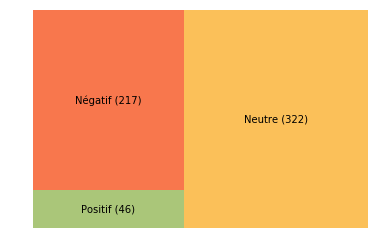

In [14]:
y=[0,0,0];
with open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'], 'rb') as f:
    for tweet in json_lines.reader(f):
        if tweet['result'] == 'Positif':
            y[0]+=1
        elif tweet['result'] == 'Negatif':
            y[1]+=1
        elif tweet['result'] == 'Neutre':
            y[2]+=1
            
x = ["Positif", "Négatif", "Neutre"];
x = [x[i] + " (" + str(y[i]) + ")" for i in range(3)]

colors=["#87AF41","#F63E02","#FAA613"];
if 0 in y:
    k=y.index(0)
    del x[k]
    del y[k]
    del colors[k]
    
squarify.plot(sizes=y, label=x, alpha=.7 ,color=colors)
plt.axis('off')
plt.show()

Liste des tweets

In [15]:
data=[["Score","Tweet"]]
with open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'], 'rb') as f:
    for tweet in json_lines.reader(f):
        data.append([tweet["result"],tweet["tweet"]["full_text"]])
t = Texttable()
t.add_rows(data)
print (t.draw())

+---------+--------------------------------------------------------------------+
|  Score  |                               Tweet                                |
+=========+====================================================================+
| Neutre  | RT @perfectsliders: How do you feel about #Trump as President?     |
|         | #MondayMotivation                                                  |
+---------+--------------------------------------------------------------------+
| Negatif | RT @T_W_Haines: Dear #Democrats:                                   |
|         |                                                                    |
|         | Doesn't really seem like the rationale of someone who colluded     |
|         | with Putin's Russia, does it? Asking for a…                        |
+---------+--------------------------------------------------------------------+
| Neutre  | RT @pollsofpolitics: What GRADE would you give @realDonaldTrump    |
|         | for his first ye